# Test different clustering methods to identify scenarios of high criticality
- PRIM
- K-means
- CART

In [1]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd

In [2]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [3]:
dbFile = 'lhs_samples/fleet_roadBlocked_scenarios.db'

In [4]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

comb_scenarios = {}
with ThreadPoolExecutor(max_workers=6) as executor:
    for result in executor.map(read_fleet_from_db, queries):
        comb_scenarios.update(result)

print(len(comb_scenarios))

Length of rows:  0
Length of rows:  34
Length of rows:  2000
Length of rows:  2000
Length of rows:  2000
6034


### Create Dataframes from the database read
- df_results: a dataframe of the results
- df: a dataframe of the inputs

In [5]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)



In [6]:
experiments = df
### Create outcomes as an array of df_results
outcomes = list(df_results[0].values)

In [7]:
### print descriptive statistics of outcomes
print(df_results.describe())


                  0
count   6032.000000
mean   18935.958223
std     4913.071413
min     9600.000000
25%    13200.000000
50%    23400.000000
75%    23400.000000
max    30000.000000



Bad key text.latex.preview in file /home/pfoytik/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pfoytik/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pfoytik/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qua

NameError: name 'plt' is not defined

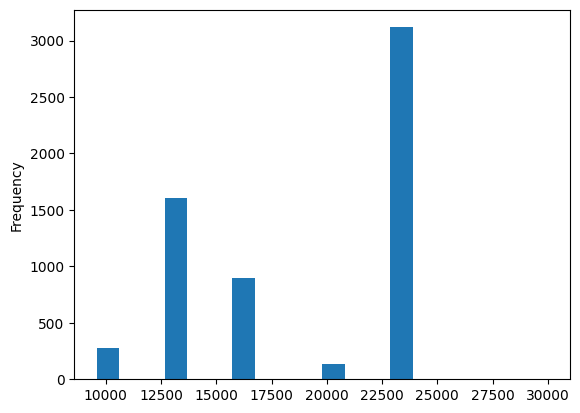

In [8]:
### Plot histogram of df_results[0]
df_results[0].plot(kind='hist', bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')
plt.title('Histogram of Time to 90% blocked')
plt.show()



In [9]:
print(len(experiments[df_results[0] > 17500]))
print(len(df_results[df_results[0] > 17500]))
print(len(df_results))

3260
3260
6034


In [10]:
### establish data sets for high and low outcomes
high_results = df_results[df_results[0] > 17500]
low_results = df_results[df_results[0] <= 17500]

### establish data sets for high and low inputs
high_inputs = experiments[df_results[0] > 17500]
low_inputs = experiments[df_results[0] <= 17500]


# Prim analysis

In [11]:
np_results = df_results[0].to_numpy()

In [12]:
np_results

array([16500., 23400., 13200., ..., 12900., 23400.,  9600.])

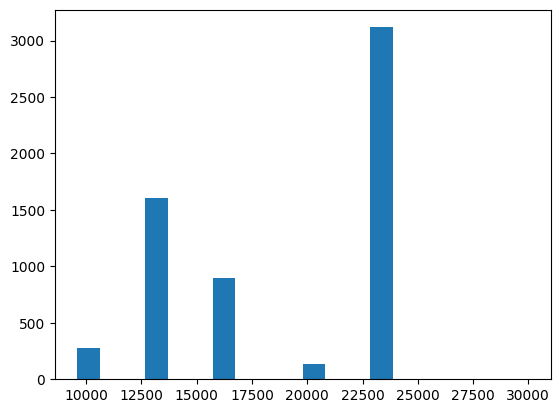

In [13]:
### plot df_results
import matplotlib.pyplot as plt

### plot histogram of df_results
plt.hist(df_results[0], bins=20)
plt.show()

In [14]:
import prim as p_rim

In [24]:
result_limits = {}

# High and Low Limits Data

In [16]:
high_results = df_results[df_results[0] > 17500]
low_results = df_results[df_results[0] <= 17500]

high_inputs = experiments[df_results[0] > 17500]
low_inputs = experiments[df_results[0] <= 17500]

In [17]:
### Print the length of high and low results and high and low inputs
print(len(high_results))
print(len(low_results))
print(len(high_inputs))
print(len(low_inputs))

3260
2772
3260
2772


# PRIM Analysis

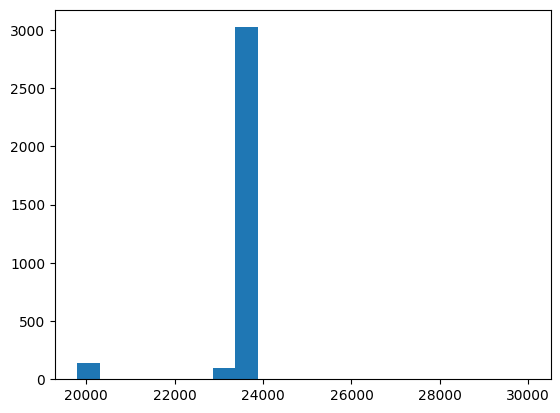

In [18]:
### show histogram of high results
plt.hist(high_results[0], bins=20)
plt.show()


In [155]:
### select random 1000 samples of high and low results
import random

### get 1000 indexes of high and low results
#high_indexes = random.sample(range(0, len(high_results)), 1000)
#low_indexes = random.sample(range(0, len(low_results)), 1000)

samp_high_results = []
samp_high_results.append(random.sample(range(0, len(high_results)), 1000))
samp_high_results.append(random.sample(range(0, len(high_results)), 1000))
samp_high_results.append(random.sample(range(0, len(high_results)), 1000))
samp_high_results.append(random.sample(range(0, len(high_results)), 1000))

samp_low_results = []
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))



In [159]:
### get the rows of high_inputs based on samp_high_results[0]
high_inputs.iloc[samp_high_results[0]]

,24501202,105574370,10091169782,10091169911,10091170028,10091170033,116937342,708957455,10708960254,709015681,...,10949283531,708749840,105538093,711443267,10105593939,1156080189,1175163236,1175073250,11173056608,10105539843
3646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5474,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4158,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
4031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4765,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5401,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [161]:
### run prim on all samp_high_results
for i in range(len(samp_high_results)):
    prim_alg = p_rim.Prim(high_inputs.iloc[samp_high_results[i]], high_results.iloc[samp_high_results[i]][0], threshold=22000.0, threshold_type=">")
    box = prim_alg.find_box()
    print(len(box.limits))
    result_limits['samp_high_results_' + str(i)] = box.limits
          

#prim_alg = p_rim.Prim(high_inputs, high_results[0], threshold=22000.0, threshold_type=">")
print(result_limits.keys())

10
12
11
9
dict_keys(['high_limits', 'low_limits', 'high_kmeans', 'low_kmeans', 'low_CART', 'high_CART', 'samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3'])


In [162]:
result_limits['samp_high_results_0']

,min,max,qp values
1173048758,0.0,0.0,0.000454
10949279384,0.0,0.0,0.001221
1175069740,0.0,0.0,0.001247
10116967913,0.0,0.0,0.008489
116941758,0.0,0.0,0.056933
10708847376,0.0,0.0,0.057189
1173040618,0.0,0.0,0.058217
91170027,0.0,0.0,0.145553
708957455,0.0,0.0,0.150432
105538876,0.0,0.0,0.381805


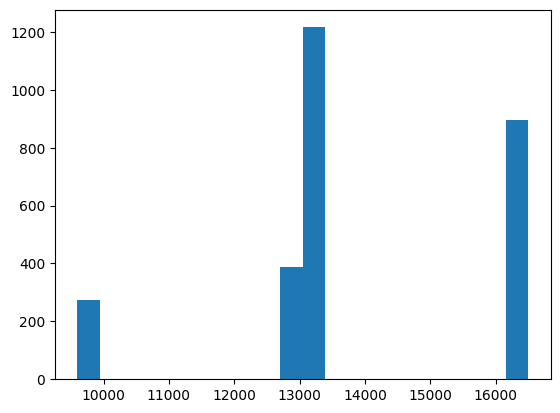

In [26]:
### plot histogram of low results
plt.hist(low_results[0], bins=20)
plt.show()

In [169]:
### run prim on all samp_low_results
for i in range(len(samp_low_results)):
    prim_alg = p_rim.Prim(low_inputs.iloc[samp_low_results[i]], low_results.iloc[samp_low_results[i]][0], threshold=14000.0, threshold_type="<")
    box = prim_alg.find_box()
    print(len(box.limits))
    result_limits['samp_low_results_' + str(i)] = box.limits
          

#prim_alg = p_rim.Prim(high_inputs, high_results[0], threshold=22000.0, threshold_type=">")
print(result_limits.keys())

34
36
31
32
dict_keys(['high_limits', 'low_limits', 'high_kmeans', 'low_kmeans', 'low_CART', 'high_CART', 'samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3', 'samp_low_results_0', 'samp_low_results_1', 'samp_low_results_2', 'samp_low_results_3', 'samp_low_limits 0', 'samp_low_limits)0', 'samp_low_limits_0'])


In [175]:
### drop key values 'samp_low_limits 0', 'samp_low_limits)0', 'samp_low_limits_0' from result_limits
print(len(result_limits.keys()))
result_limits.keys()



14


dict_keys(['high_limits', 'low_limits', 'high_kmeans', 'low_kmeans', 'low_CART', 'high_CART', 'samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3', 'samp_low_results_0', 'samp_low_results_1', 'samp_low_results_2', 'samp_low_results_3'])

In [174]:
result_limits['samp_low_results_1']

,min,max,qp values
10116941758,0.0,0.0,0.000023
10710783587,0.0,0.0,0.000153
10708953021,0.0,0.0,0.002628
11156090945,0.0,0.0,0.002785
11155656403,0.0,0.0,0.003115
10710782580,0.0,0.0,0.007365
127847593,0.0,0.0,0.007483
10105574033,0.0,0.0,0.007843
11173040620,0.0,0.0,0.008213
1155878763,0.0,0.0,0.008466


# KMeans tests

In [54]:
### cluster the results
from sklearn.cluster import KMeansefae0b

### kmeans cluster the columns of high_inputs
kmeans = KMeans(n_clusters=4, random_state=21).fit(high_inputs.T)

### print the count of each cluster
print(pd.Series(kmeans.labels_).value_counts())


0    202
1    191
3    159
2     27
dtype: int64


In [58]:
### print the labels for cluster 2
print(high_inputs.columns[kmeans.labels_ == 2])




Index(['10091169783', '91167825', '91169890', '11173048760', '704060377',
       '10105593568', '10704060378', '710783586', '10091169901', '10708503028',
       '91170618', '105539865', '10949290451', '949790370', '10091170041',
       '709015679', '10091170205', '11173060573', '127825678', '127847572',
       '1173040618', '91169787', '91170209', '711121754', '10708957455',
       '1172978482', '105537706'],
      dtype='object')


In [59]:
result_limits['high_kmeans'] = kmeans

In [60]:
### kmeans cluster the columns of high_inputs
kmeans = KMeans(n_clusters=4, random_state=21).fit(low_inputs.T)

### print the count of each cluster
print(pd.Series(kmeans.labels_).value_counts())

1    191
3    152
2    123
0    113
dtype: int64


In [61]:
result_limits['low_kmeans'] = kmeans

In [62]:
print(len(result_limits))

4


In [98]:
### get the index's of results for each cluster
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

idx0 = []
idx1 = []
idx2 = []
idx3 = []

for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] == 0:
        cluster0.append(df_resultsMAX[0].iloc[i])
        idx0.append(i)
    elif kmeans.labels_[i] == 1:
        cluster1.append(df_resultsMAX[0].iloc[i])
        idx1.append(i)
    elif kmeans.labels_[i] == 2:
        cluster2.append(df_resultsMAX[0].iloc[i])
        idx2.append(i)
    elif kmeans.labels_[i] == 3:
        cluster3.append(df_resultsMAX[0].iloc[i])
        idx3.append(i)

len(cluster0)

41

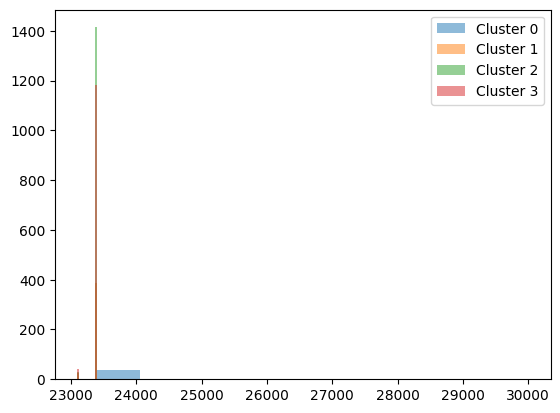

In [99]:
### plot a histogram all the clusters
plt.hist(cluster0, bins=10, alpha=0.5, label='Cluster 0')
plt.hist(cluster1, bins=10, alpha=0.5, label='Cluster 1')
plt.hist(cluster2, bins=10, alpha=0.5, label='Cluster 2')
plt.hist(cluster3, bins=10, alpha=0.5, label='Cluster 3')
plt.legend(loc='upper right')
plt.show()

In [100]:
### print colum names of df.iloc[idx0] that have values greater than 0
print(len(df.iloc[idx0].columns[(df.iloc[idx0] > 0).any()]))
print(len(df.iloc[idx1].columns[(df.iloc[idx1] > 0).any()]))
print(len(df.iloc[idx2].columns[(df.iloc[idx2] > 0).any()]))
print(len(df.iloc[idx3].columns[(df.iloc[idx3] > 0).any()]))



507
579
579
579


In [130]:
### for each df.iloc[idx0] print the sum of all columns sorted from highest to lowest
print(df.iloc[idx0].sum().sort_values(ascending=False))

### get the top 10 columns of df.iloc[idx0] that have the highest sum
maxSegs0 = df.iloc[idx0].sum().sort_values(ascending=False).head(200)
maxSegs1 = df.iloc[idx1].sum().sort_values(ascending=False).head(200)
maxSegs2 = df.iloc[idx2].sum().sort_values(ascending=False).head(200)
maxSegs3 = df.iloc[idx3].sum().sort_values(ascending=False).head(200)


116967913      7
91169782       7
949300629      7
10915734790    7
711115701      6
              ..
10091170132    0
711379673      0
1156005087     0
711251380      0
105537445      0
Length: 579, dtype: int64


In [131]:
overlaps = []
### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx1]
overlap = maxSegs0.index.intersection(maxSegs1.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx2]
overlap = maxSegs0.index.intersection(maxSegs2.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx3]
overlap = maxSegs0.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx1] and df.iloc[idx2]
overlap = maxSegs1.index.intersection(maxSegs2.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx1] and df.iloc[idx3]
overlap = maxSegs1.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx2] and df.iloc[idx3]
overlap = maxSegs2.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)


Index(['116967913', '10915734790', '10711209710', '710783587', '10915734793',
       '10946271023', '91435359', '10709015679', '10711121748', '10949397063',
       '1175069740', '91170205', '10708958458', '949279124', '105593873',
       '11173060575', '704124376', '105540011', '10710782580', '10703777459',
       '10127825675', '105574067', '10105574368', '703777459', '10703777750',
       '105593568', '949290447', '1156080182', '1116878000', '949397070',
       '10708548339', '1173048757', '116964285', '105539210', '10105538098',
       '10105593499', '1156090945', '10105537958', '24501202', '10105537672',
       '105539772', '105538755', '11173040622', '11173048767', '10704061070',
       '703766145', '91169778', '10711379673', '91170619', '10105540066',
       '937800492', '10105537818', '105593939', '708957454', '116970510',
       '11172978481', '10091167864', '105574369', '11155878755', '10116952815',
       '709015681', '1156083863', '105593941', '10710782582', '711440306',
   

In [138]:
for o in overlaps:
    for i in o:
        if i in primSegments:
            print(i)

999850568
10105576311
116951485
1155656405
10711443269


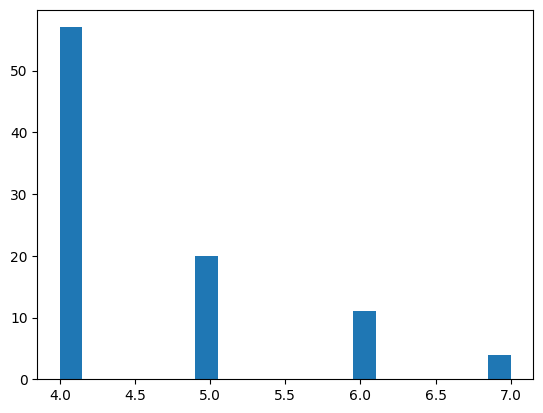

# CART Tests
- low coverage values indicate boxes of rare specific behaviors
- high coverage values indicate boxes of general themes
- res dim indicates the number of features associated with the variation

In [116]:
### perform CART on the high inputs and high results
import ema_workbench.analysis.cart as CART

ca = CART.CART(low_inputs, low_results[0])
ca.build_tree()

In [118]:
print(ca.stats_to_dataframe())

       coverage       density  res dim      mass
box 1  0.627756  13894.991364        7  0.626623
box 2  0.048947  13538.848921        7  0.050144
box 3  0.051460  14132.142857        6  0.050505
box 4  0.057749  14142.038217        5  0.056638
box 5  0.051327  13516.438356        4  0.052670
box 6  0.054370  13843.708609        3  0.054473
box 7  0.056594  13684.905660        2  0.057359
box 8  0.051795  13925.874126        1  0.051587


In [119]:
print(ca.boxes_to_dataframe())

            box 1      box 2      box 3      box 4      box 5      box 6       \
              min  max   min  max   min  max   min  max   min  max   min  max   
11172854308   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   
116970509     0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
105575352     0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
1173040617    0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0   
10112037948   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   
1172978480    0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   
10091170208   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   

            box 7      box 8       
              min  max   min  max  
11172854308   0.0  1.0   0.0  1.0  
116970509     0.5  1.0   0.0  1.0  
105575352     0.0  0.5   0.5  1.0  
1173040617    0.0  1.0   0.0  1.0  
10112037948   0.0  1.0   0.0  1.0  
1172978480    0.0 

In [120]:
boxesdf = ca.boxes_to_dataframe()
boxesdf['box 8']

,min,max
11172854308,0.0,1.0
116970509,0.0,1.0
105575352,0.5,1.0
1173040617,0.0,1.0
10112037948,0.0,1.0
1172978480,0.0,1.0
10091170208,0.0,1.0


In [121]:
for i in range(1, 8):
    print(len(boxesdf['box {}'.format(i)]))

7
7
7
7
7
7
7


In [123]:
result_limits['low_CART'] = ca

In [176]:
### Run CART on samp_low_results
for i in range(len(samp_low_results)):
    ca = CART.CART(low_inputs.iloc[samp_low_results[i]], low_results.iloc[samp_low_results[i]][0])
    ca.build_tree()
    print(ca.stats_to_dataframe())
    print(ca.boxes_to_dataframe())
    result_limits['samp_low_CART_' + str(i)] = ca

       coverage       density  res dim   mass
box 1  0.575586  13955.749129        8  0.574
box 2  0.054946  14161.111111        8  0.054
box 3  0.052984  13913.207547        7  0.053
box 4  0.049083  13662.000000        6  0.050
box 5  0.054774  13373.684211        5  0.057
box 6  0.050355  13476.923077        4  0.052
box 7  0.051583  13545.283019        3  0.053
box 8  0.058115  14977.777778        2  0.054
box 9  0.052575  13805.660377        1  0.053
            box 1      box 2      box 3      box 4      box 5      box 6       \
              min  max   min  max   min  max   min  max   min  max   min  max   
10949290445   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
10120406152   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0   
10949397061   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   
10711543791   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   
105593842     0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.

In [125]:
ca = CART.CART(high_inputs, high_results[0])
ca.build_tree()

print(ca.stats_to_dataframe())

print(ca.boxes_to_dataframe())

boxesdf = ca.boxes_to_dataframe()
boxesdf.head()

        coverage       density  res dim      mass
box 1   0.501186  23199.144777        9  0.502147
box 2   0.052617  23315.789474        9  0.052454
box 3   0.056806  23393.478261        8  0.056442
box 4   0.051572  23400.000000        7  0.051227
box 5   0.056513  23400.000000        6  0.056135
box 6   0.062380  23400.000000        5  0.061963
box 7   0.054533  22956.666667        4  0.055215
box 8   0.051908  23137.058824        3  0.052147
box 9   0.057142  23279.032258        2  0.057055
box 10  0.055345  23298.333333        1  0.055215
            box 1      box 2      box 3      box 4      box 5      box 6       \
              min  max   min  max   min  max   min  max   min  max   min  max   
1172872766    0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   
10091170129   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
105574033     0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
10091170618   0.0  0.5   0.5  1.0   0.0  1.0 

box 1      box 2      box 3      box 4      box 5      box 6       \
              min  max   min  max   min  max   min  max   min  max   min  max   
1172872766    0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   
10091170129   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
105574033     0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
10091170618   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0   
116945306     0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   

            box 7      box 8      box 9      box 10       
              min  max   min  max   min  max    min  max  
1172872766    0.0  1.0   0.0  1.0   0.0  1.0    0.0  1.0  
10091170129   0.5  1.0   0.0  1.0   0.0  1.0    0.0  1.0  
105574033     0.0  0.5   0.5  1.0   0.0  1.0    0.0  1.0  
10091170618   0.0  1.0   0.0  1.0   0.0  1.0    0.0  1.0  
116945306     0.0  0.5   0.0  0.5   0.5  1.0    0.0  1.0

In [126]:
result_limits['high_CART'] = ca

In [177]:
### Run CART on samp_high_results
for i in range(len(samp_high_results)):
    ca = CART.CART(high_inputs.iloc[samp_high_results[i]], high_results.iloc[samp_high_results[i]][0])
    ca.build_tree()
    print(ca.stats_to_dataframe())
    print(ca.boxes_to_dataframe())
    result_limits['samp_high_CART_' + str(i)] = ca

        coverage       density  res dim   mass
box 1   0.495161  23273.076923        9  0.494
box 2   0.051386  23394.117647        9  0.051
box 3   0.062485  23400.000000        8  0.062
box 4   0.062485  23400.000000        7  0.062
box 5   0.054784  23127.272727        6  0.055
box 6   0.054926  23187.272727        5  0.055
box 7   0.051735  23100.000000        4  0.052
box 8   0.057058  22841.379310        3  0.058
box 9   0.056179  23292.857143        2  0.056
box 10  0.053802  22712.727273        1  0.055
            box 1      box 2      box 3      box 4      box 5      box 6       \
              min  max   min  max   min  max   min  max   min  max   min  max   
1172872766    0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   
91170619      0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0   
91169782      0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   
1155878750    0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0 

In [178]:
print(len(result_limits))

22


In [179]:
result_limits.keys()

dict_keys(['high_limits', 'low_limits', 'high_kmeans', 'low_kmeans', 'low_CART', 'high_CART', 'samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3', 'samp_low_results_0', 'samp_low_results_1', 'samp_low_results_2', 'samp_low_results_3', 'samp_low_CART_0', 'samp_low_CART_1', 'samp_low_CART_2', 'samp_low_CART_3', 'samp_high_CART_0', 'samp_high_CART_1', 'samp_high_CART_2', 'samp_high_CART_3'])

In [139]:
### create function go get feature names from prim limits
def get_feature_names(limits):
    feature_names = []
    for key in list(limits.index):        
        feature_names.append(key)
    return feature_names

def get_kmeans_features(df, kmeans, cluster):
    return df.columns[kmeans.labels_ == cluster]


['10949279384', '10708847376', '105537673', '1155656405', '708548339', '1173048758', '10105538098', '10708958457', '10112036712', '10708549612', '1172978482']


In [153]:
### Get the features from PRIM
print(get_feature_names(result_limits['high_limits']))

### Get the features from the kmeans
print(list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 2]))

### get the feature names from the cart
print(get_feature_names(result_limits['high_CART'].boxes_to_dataframe()['box 2']))

### print the number of clusters in result_limits['high_kmeans']
print(len(pd.Series(result_limits['high_kmeans'].labels_).value_counts()))
### print the number of boxes in result_limits['high_CART']
print(len(result_limits['high_CART'].boxes_to_dataframe()))


['10949279384', '10708847376', '105537673', '1155656405', '708548339', '1173048758', '10105538098', '10708958457', '10112036712', '10708549612', '1172978482']
['10091169783', '91167825', '91169890', '11173048760', '704060377', '10105593568', '10704060378', '710783586', '10091169901', '10708503028', '91170618', '105539865', '10949290451', '949790370', '10091170041', '709015679', '10091170205', '11173060573', '127825678', '127847572', '1173040618', '91169787', '91170209', '711121754', '10708957455', '1172978482', '105537706']
['1172872766', '10091170129', '105574033', '10091170618', '116945306', '10116945306', '10112037376', '91170618', '711522483']
4
9


In [180]:
highClusters = {}
highClusters['prim'] = get_feature_names(result_limits['high_limits'])
highClusters['prim1'] = get_feature_names(result_limits['samp_high_results_0'])
highClusters['prim2'] = get_feature_names(result_limits['samp_high_results_1'])
highClusters['prim3'] = get_feature_names(result_limits['samp_high_results_2'])
highClusters['prim4'] = get_feature_names(result_limits['samp_high_results_3'])
highClusters['kmeans'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 0])
highClusters['kmeans1'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 1])
highClusters['kmeans2'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 2])
highClusters['kmeans3'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 3])
highClusters['cart'] = get_feature_names(result_limits['high_CART'].boxes_to_dataframe()['box 2'])
highClusters['cart1'] = get_feature_names(result_limits['samp_high_CART_0'].boxes_to_dataframe()['box 2'])
highClusters['cart2'] = get_feature_names(result_limits['samp_high_CART_1'].boxes_to_dataframe()['box 2'])
highClusters['cart3'] = get_feature_names(result_limits['samp_high_CART_2'].boxes_to_dataframe()['box 2'])
highClusters['cart4'] = get_feature_names(result_limits['samp_high_CART_3'].boxes_to_dataframe()['box 2'])


lowClusters = {}
lowClusters['prim'] = get_feature_names(result_limits['low_limits'])
lowClusters['prim1'] = get_feature_names(result_limits['samp_low_results_0'])
lowClusters['prim2'] = get_feature_names(result_limits['samp_low_results_1'])
lowClusters['prim3'] = get_feature_names(result_limits['samp_low_results_2'])
lowClusters['prim4'] = get_feature_names(result_limits['samp_low_results_3'])
lowClusters['kmeans'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 0])
lowClusters['kmeans1'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 1])
lowClusters['kmeans2'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 2])
lowClusters['kmeans3'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 3])
lowClusters['cart'] = get_feature_names(result_limits['low_CART'].boxes_to_dataframe()['box 2'])
lowClusters['cart1'] = get_feature_names(result_limits['samp_low_CART_0'].boxes_to_dataframe()['box 2'])
lowClusters['cart2'] = get_feature_names(result_limits['samp_low_CART_1'].boxes_to_dataframe()['box 2'])
lowClusters['cart3'] = get_feature_names(result_limits['samp_low_CART_2'].boxes_to_dataframe()['box 2'])
lowClusters['cart4'] = get_feature_names(result_limits['samp_low_CART_3'].boxes_to_dataframe()['box 2'])

### Find similar features from the 3 clusters

In [190]:
### for each highClusters find the intersection of the features
hc_count = {}
for hc in highClusters.keys():
    print(hc)
    for hc2 in highClusters.keys():
        if hc != hc2:            
            print("\t",hc2)
            intersect = set(highClusters[hc]).intersection(set(highClusters[hc2]))
            print("\t", intersect)
            for i in intersect:
                if i in hc_count.keys():
                    hc_count[i] += 1
                else:
                    hc_count[i] = 1
                  
print(" ------------------------------------ ")

lc_count = {}
### for each lowClusters find the intersection of the features
for lc in lowClusters.keys():
    print(lc)
    for lc2 in lowClusters.keys():
        if lc != lc2:            
            print("\t", lc2)
            intersect = set(lowClusters[lc]).intersection(set(lowClusters[lc2]))
            print("\t", intersect)
            for i in intersect:
                if i in lc_count.keys():
                    lc_count[i] += 1
                else:
                    lc_count[i] = 1


prim
	 prim1
	 {'1173048758', '10949279384', '10708847376'}
	 prim2
	 {'10105538098', '105537673'}
	 prim3
	 {'10105538098', '708548339'}
	 prim4
	 {'10708958457', '10708847376'}
	 kmeans
	 {'10112036712', '1173048758', '10708549612', '10708958457', '708548339'}
	 kmeans1
	 {'10105538098', '1155656405', '10949279384', '10708847376'}
	 kmeans2
	 {'1172978482'}
	 kmeans3
	 {'105537673'}
	 cart
	 set()
	 cart1
	 {'708548339', '10949279384'}
	 cart2
	 {'10949279384'}
	 cart3
	 {'1173048758', '708548339'}
	 cart4
	 set()
prim1
	 prim
	 {'1173048758', '10949279384', '10708847376'}
	 prim2
	 set()
	 prim3
	 set()
	 prim4
	 {'10708847376'}
	 kmeans
	 {'116941758', '1173048758'}
	 kmeans1
	 {'10708847376', '708957455', '1175069740', '91170027', '10949279384'}
	 kmeans2
	 {'1173040618'}
	 kmeans3
	 {'105538876', '10116967913'}
	 cart
	 set()
	 cart1
	 {'10949279384'}
	 cart2
	 {'10949279384'}
	 cart3
	 {'1173040618', '116941758', '1173048758', '10116967913'}
	 cart4
	 set()
prim2
	 prim
	 {'1010

In [191]:
lc_count

{'1172872766': 12,
 '1156083863': 30,
 '10709015680': 12,
 '11156090945': 30,
 '710782582': 12,
 '10709017866': 30,
 '10708958458': 20,
 '10709015681': 30,
 '709015681': 6,
 '11156083866': 30,
 '709017866': 6,
 '91169911': 20,
 '105539865': 6,
 '10091169911': 6,
 '1155878763': 6,
 '10105574033': 20,
 '10704124376': 6,
 '10710783587': 20,
 '91169784': 12,
 '91170120': 6,
 '708749840': 12,
 '11173056608': 6,
 '91169778': 6,
 '105593453': 6,
 '1175073250': 6,
 '10711376239': 2,
 '1172855239': 2,
 '127847573': 2,
 '11156083863': 2,
 '10116970509': 2,
 '710783587': 2,
 '105541877': 2,
 '10704060378': 2,
 '10116946397': 2,
 '1173056608': 2,
 '1156090945': 20,
 '91169782': 6,
 '709015679': 20,
 '709015680': 12,
 '949279124': 6,
 '1156083866': 2,
 '127847572': 2,
 '105537672': 2,
 '10105593568': 2,
 '1175073251': 2,
 '10710783586': 2,
 '1156080187': 2,
 '11172855239': 2,
 '10709015679': 2,
 '10949397068': 6,
 '1156083854': 2,
 '10711245842': 2,
 '1155878750': 2,
 '11156804029': 2,
 '1094928323

In [197]:
### write hc_count to json
import json

with open('hc_count.json', 'w') as f:
    json.dump(hc_count, f)

with open('lc_count.json', 'w') as f:
    json.dump(lc_count, f)

### write high_clusters to json
with open('high_clusters.json', 'w') as f:
    json.dump(highClusters, f)

### write low_clusters to json
with open('low_clusters.json', 'w') as f:
    json.dump(lowClusters, f)


In [198]:
### read in hc_count.json
with open('hc_count.json', 'r') as f:
    hc_count_json = json.load(f)

### read in lc_count.json
with open('lc_count.json', 'r') as f:
    lc_count_json = json.load(f)

### read in high_clusters.json
with open('high_clusters.json', 'r') as f:
    high_clusters_json = json.load(f)

### read in low_clusters.json
with open('low_clusters.json', 'r') as f:
    low_clusters_json = json.load(f)